# Face Detection using HOG Features and an SVM Classifier

## Description
Face Detection is a computer vision problem that aims to attempt to accurately identify human faces that may, or may not, be present in a given photograph or video. Many efforts have been directed at this problem since the early 2000's, with it having started as a subbranch of the problem of Object-Class Detection but having evolved into a main focus of machine learning algorithms due to its prevalence and paramountcy to the paradigm of Facial Recognition, another problem that is nowadays used in a wide-branch of technologies and biometrics.

## Face Detection Function

### Imports

In [1]:
import cv2
import os
from os import listdir
from os.path import isfile, join
from time import time
from matplotlib import pyplot as plt

from skimage.feature import hog
from skimage import data, color, feature, exposure

from sklearn import svm
from sklearn.metrics import classification_report,accuracy_score

from sklearn.utils import shuffle

from sklearn.model_selection import GridSearchCV

import numpy as np

### Creating the HOG Images

#### Resize and Grayscale Images

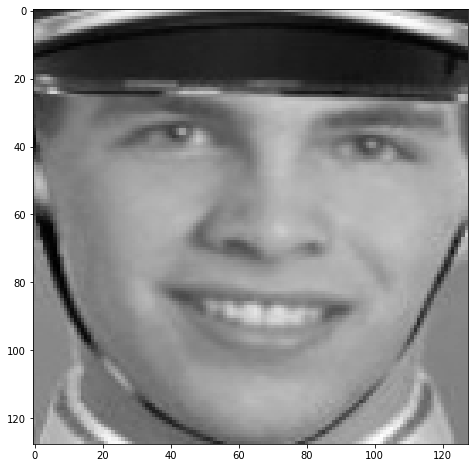

In [2]:
img = cv2.imread('./ImageResources/Dataset/WIDER_train/cropped_images/positive/Image0.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, (128,128), interpolation = cv2.INTER_AREA) 


#cv2.imshow("Detected Faces", img)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

plt.figure(figsize=(12,8))
plt.imshow(img, cmap='gray')
plt.show()

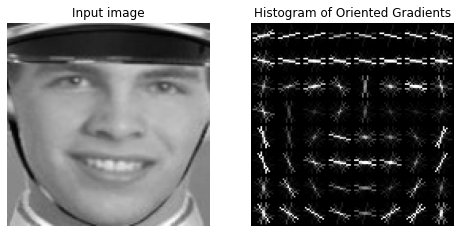

In [3]:
fd, hog_image = hog(img, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(img, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()


### Positive Train Set

In [4]:
x_train = []
y_train = []
positive_patch = []
negative_patch = []

path = "./ImageResources/Dataset/WIDER_train/cropped_images/"

print("Creating Positive HOG")
with open(path+"positive_info.dat", "r") as reader:
    for line in reader:
        line = line.split("\t")[0]
        img = cv2.imread(path+line)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (128,128), interpolation = cv2.INTER_AREA) 
        positive_patch.append(img)

        hog_features, hog_image = hog(img, orientations=8, pixels_per_cell=(16, 16),
                        cells_per_block=(1, 1), visualize=True)

        x_train.append(hog_features)
        y_train.append(1)

print("Creating Negative HOG")
with open(path+"negative_info.txt", "r") as reader:
    for line in reader:
        line = line[:-1]
        img = cv2.imread(path+line)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (128,128), interpolation = cv2.INTER_AREA) 
        negative_patch.append(img)

        hog_features, hog_image = hog(img, orientations=8, pixels_per_cell=(16, 16),
                        cells_per_block=(1, 1), visualize=True)

        x_train.append(hog_features)
        y_train.append(0)

Creating Positive HOG
Creating Negative HOG


In [5]:
x_train = np.array(x_train)
y_train = np.array(y_train)

print("Shuffling")
x_train, y_train = shuffle(x_train, y_train)

Shuffling


### Training SVC (State Vector Classifier)

In [ ]:
#Note. to test for the LinearSVC just replace SVC() with LinearSVC()
grid = GridSearchCV(svm.SVC(), {'C': [1.0, 2.0, 4.0, 8.0]})
grid.fit(x_train, y_train)
grid.best_score_
grid.best_params_

In [ ]:
model = grid.best_estimator_
model.fit(x_train, y_train)

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(x_train, y_train)

In [34]:
def sliding_window(img, patch_size=(128, 128),
                   istep=2, jstep=2, scale=1.0):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Nj, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            yield (i, j), patch



In [35]:
img = cv2.imread('./ImageResources/Dataset/WIDER_train/cropped_images/positive/Image0.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, (200,200), interpolation = cv2.INTER_AREA) 

indices, patches = zip(*sliding_window(img))
print(patches[0].shape)
patches_hog = np.array([hog(patch, orientations=8, pixels_per_cell=(16, 16),
                        cells_per_block=(1, 1), visualize=True)[0] for patch in patches])

predictoins = model.predict(patches_hog)

print(predictoins.sum())

(128, 128)
1271


In [36]:
def binary_test(model, image_dir):
    list_imgs = [join(image_dir, f).rstrip() for f in listdir(image_dir) if isfile(join(image_dir, f))]
    true_pos = 0
    true_neg = 0
    false_pos = 0
    false_neg = 0
    timer = 0
    
    for img_dir in list_imgs:
        img = cv2.imread(img_dir)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (128, 128), interpolation = cv2.INTER_AREA) 
        
        start = time()
        img_hog = hog(img, orientations=8, pixels_per_cell=(16, 16),
                                cells_per_block=(1, 1), visualize=True)[0]
        
        predictoins = model.predict([img_hog])
        timer += time() - start
        
        answer = img_dir.split("/")[-1][:3]
        
        if predictoins.sum() >= 1:
            if answer == "Pos": #It's a positive image, we check if width and height are closer to the image
                true_pos += 1
            else:
                false_pos += 1
        else:
            if answer == "Neg":
                true_neg += 1
            else:
                false_neg += 1
                
    return true_pos, true_neg, false_pos, false_neg, timer
            

In [37]:
print(binary_test(model, "./ImageResources/Dataset/WIDER_test/cropped_images"))

(9587, 9772, 229, 409, 265.5678815841675)


In [ ]:
# LinearSVC -> (8642, 9551, 450, 1354, 214.64090061187744)

# SVC -> (9587, 9772, 229, 409, 265.5678815841675)